In [1]:
import cdlib
import pandas as pd
import networkx as nx
from cdlib import algorithms
from collections import Counter
import plotly.express as px
from cdlib import evaluation
from cdlib import viz
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools

Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'graph_tool', 'karateclub', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'wurlitzer'}


# Graph Generation

In [2]:
node_list = pd.read_csv('data/bd-node.csv', index_col = 'id')
edge_list = pd.read_csv('data/bd-edge.csv')

In [3]:
node_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11775 entries, 0 to 20498
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   titolo                    11775 non-null  object 
 1   autore                    11775 non-null  object 
 2   editore                   11775 non-null  object 
 3   categoria                 11775 non-null  object 
 4   raccomandazioni-ricevute  11775 non-null  float64
 5   anno-pubblicazione        11775 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 643.9+ KB


In [4]:
node_list.head()

,titolo,autore,editore,categoria,raccomandazioni-ricevute,anno-pubblicazione
id,,,,,,
0,Cambiare l'acqua ai fiori,Perrin Valérie,E/O,Letterature straniere: testi,64.0,2019
1,"Ragazza, donna, altro",Evaristo Bernardine,Sur,Letterature straniere: testi,61.0,2020
2,L'Ickabog,Rowling J. K.,Salani,Letteratura per ragazzi,44.0,2020
3,Dante,Barbero Alessandro,Laterza,Letteratura italiana: critica,37.0,2020
4,Borgo Sud,Di Pietrantonio Donatella,Einaudi,Letteratura italiana: testi,36.0,2020


In [5]:
g = nx.from_pandas_edgelist(edge_list, 'Source', 'Target', ['Weight'])

In [6]:
# Create a nested dict with info for each node of the nodelist
info_nodes = {}

for index, row in node_list.iterrows():
    info_nodes[index] = {'book_name': row['titolo'], 
                         'book_author': row['autore'], 
                         'book_publisher': row['editore'],
                         'book_genre': row['categoria'], 
                         'recommendations_received' : row['raccomandazioni-ricevute'], 
                         'year_of_publication': row['anno-pubblicazione']}

In [7]:
info_nodes[11818]

{'book_name': 'Hokusai. Pop-up',
 'book_author': 'McCarthy Courtney Watson',
 'book_publisher': 'White Star',
 'book_genre': 'Disegno, arti decorative e minori',
 'recommendations_received': 1.0,
 'year_of_publication': 2016}

In [8]:
len(info_nodes)

11775

In [9]:
len(nx.nodes(g))

11775

In [10]:
# Setting the attributes of each node using the info contained in the nested dict
nx.set_node_attributes(g, info_nodes)

In [11]:
# Get node attributes:

name = nx.get_node_attributes(g, "book_name")
author = nx.get_node_attributes(g, "book_author")
publisher = nx.get_node_attributes(g, "book_publisher")
genre = nx.get_node_attributes(g, "book_genre")
recommendations = nx.get_node_attributes(g, "recommendations_received")
year = nx.get_node_attributes(g, "year_of_publication")

In [12]:
genre[11818]

'Disegno, arti decorative e minori'

In [13]:
name[11818]

'Hokusai. Pop-up'

In [14]:
# Use the giant component
comps = list(nx.connected_components(g))
GC = g.subgraph(comps[0])
g = GC

In [15]:
len(g)

11573

# Community Discovery algorithms

## Approach 1: Internal Density
Communities as sets of densely connected entities
Each community must have a number of edges significantly higher than what expected in a random graph

### Louvain

It works finding a function of density and maxime it.


In [16]:
louv_coms = algorithms.louvain(g, weight='weight', resolution=1.)

In [17]:
louv_coms.method_name

'Louvain'

In [18]:
# Function to retrieve the info of the communities found out by the algorithm
def info_community(communities, algorithm):    
    C = [g.subgraph(c).copy() for c in communities]
    # Build a list with all info
    info = dict()    
    for count, comm in enumerate(C):        
        info[count] = {'nodes': nx.number_of_nodes(comm), 
                       'edges': nx.number_of_edges(comm)}
    return info

In [19]:
info_louv = info_community(louv_coms.communities, louv_coms)
info_louv

{0: {'nodes': 1798, 'edges': 156850},
 1: {'nodes': 1666, 'edges': 83648},
 2: {'nodes': 1551, 'edges': 86872},
 3: {'nodes': 977, 'edges': 39339},
 4: {'nodes': 754, 'edges': 52510},
 5: {'nodes': 750, 'edges': 36177},
 6: {'nodes': 515, 'edges': 21552},
 7: {'nodes': 496, 'edges': 26562},
 8: {'nodes': 465, 'edges': 63408},
 9: {'nodes': 420, 'edges': 13649},
 10: {'nodes': 351, 'edges': 25663},
 11: {'nodes': 306, 'edges': 40611},
 12: {'nodes': 286, 'edges': 10735},
 13: {'nodes': 249, 'edges': 8753},
 14: {'nodes': 209, 'edges': 5979},
 15: {'nodes': 202, 'edges': 18193},
 16: {'nodes': 164, 'edges': 7268},
 17: {'nodes': 156, 'edges': 10914},
 18: {'nodes': 87, 'edges': 3741},
 19: {'nodes': 84, 'edges': 3486},
 20: {'nodes': 34, 'edges': 561},
 21: {'nodes': 17, 'edges': 136},
 22: {'nodes': 15, 'edges': 105},
 23: {'nodes': 11, 'edges': 55},
 24: {'nodes': 10, 'edges': 45}}

In [20]:
print(f"Nodes: {evaluation.size(g, louv_coms)}")
print(f"Edges: {evaluation.edges_inside(g, louv_coms)}")
if louv_coms.overlap: 
    print('Overlapping')
else: print('No overlapping')

Nodes: FitnessResult(min=10, max=1798, score=462.92, std=512.2056555720562)
Edges: FitnessResult(min=45, max=156850, score=28672.48, std=36137.66745114577)
No overlapping


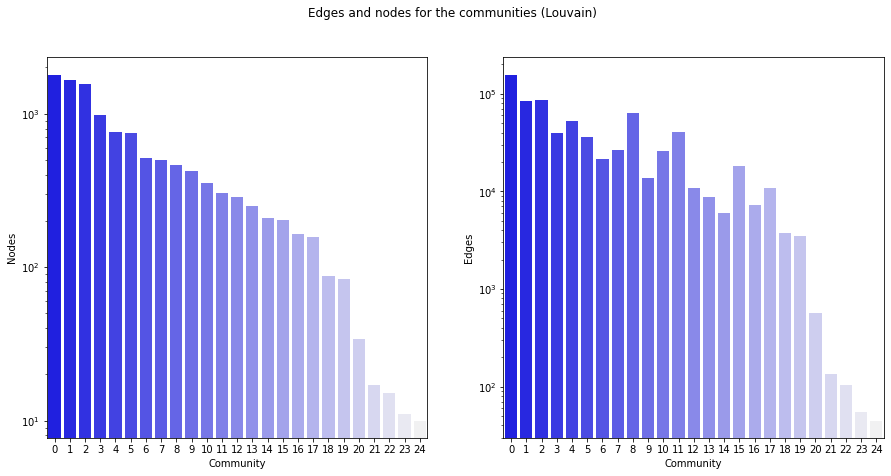

In [21]:
fig, axes = plt.subplots(1,2, figsize=(15, 7))

sns.barplot(ax=axes[0], 
            x=list(info_louv.keys()), 
            y=[c['nodes'] for c in info_louv.values()],
            palette='light:b_r')

axes[0].set_xlabel('Community')
axes[0].set_ylabel('Nodes')
axes[0].set_yscale('log')

sns.barplot(ax=axes[1],
            x=list(info_louv.keys()),
            y=[c['edges'] for c in info_louv.values()],
            palette='light:b_r')

axes[1].set_xlabel('Community')
axes[1].set_ylabel('Edges')
axes[1].set_yscale('log')

plt.suptitle("Edges and nodes for the communities (Louvain)")
plt.show()

#### Internal Evaluation: Fitness scores

##### Partitions quality functions
Using some fitness functions that can be defined to assess the quality of a partition

In [22]:
def fitness_functions(community_type):

    print("INTERNAL EVALUATION")
    print()
    #average internal degree (AID) = the average internal degree of the community set.
    print(f"1 - Average Internal Degree: \n{evaluation.average_internal_degree(g, community_type)}")
    print()
    print()
    #internal edge density (IED) = The internal density of the community set.
    print(f"2 - Internal Edge Density: \n{evaluation.internal_edge_density(g,community_type)}")
    print()
    print()
    #conductance (C) = Fraction of total edge volume that points outside the community.
    print(f"3 - Conductance : \n{evaluation.conductance(g,community_type)}")
    print()
    print()
    # Triangle participation ratio (TPR) = Fraction of community nodes that belong to a triad.
    print(f"4 - Triangle Participation Ratio : \n{evaluation.triangle_participation_ratio(g,community_type)}")
    print()
    print()
    # #Girvan-Newmann modularity (GNM)
    print(f"5 - Newmann modularity : \n{evaluation.newman_girvan_modularity(g,community_type)}")
    print()
    print()
    #Expansion = Number of edges per community node that point outside the cluster.
    print(f"6 - Expansion : \n{evaluation.expansion(g,community_type)}")
    print()
    print()
    #Normalized-cut (NC)= normalized variant of cut-ratio, that is the fraction of existing edges (out of all possible edges) leaving the community.
    print(f"7 - Normalized cut : \n{evaluation.normalized_cut(g,community_type)}")
    print()
    print()
    #Average ODF Degree (AODFD): the average fraction of edges of a node of a community that point outside the community itself.
    print(f"8 - Average ODF Degree : \n{evaluation.avg_odf(g,community_type)}")
    print()
    print()
    #Flake ODF = Fraction of nodes in S that have fewer edges pointing inside than to the outside of the community.
    print(f"9 - Flake ODF : \n{evaluation.flake_odf(g,community_type)}")
    print()
    print()
    # Fraction over median degree = Fraction of community nodes of having internal degree higher than the median degree value.
    print(f"10 - Fraction over median degree : \n{evaluation.fraction_over_median_degree(g,community_type)}")
    print()
    print()
    # Node_coverage = Fraction of total edge volume that points outside the community.
    print(f"11 - Node coverage : \n{community_type.node_coverage}")




In [23]:
fitness_functions(louv_coms)

INTERNAL EVALUATION

1 - Average Internal Degree: 
FitnessResult(min=9.0, max=272.7225806451613, score=100.22605935634743, std=68.05523208834785)


2 - Internal Edge Density: 
FitnessResult(min=0.06031097123534098, max=1.0, score=0.5280294039565608, std=0.38049573821546995)


3 - Conductance : 
FitnessResult(min=0.09090909090909091, max=0.3833770915788236, score=0.23407276790048498, std=0.08726826010517087)


4 - Triangle Participation Ratio : 
FitnessResult(min=0.9943019943019943, max=1.0, score=0.9992986395883485, std=0.0013341391012476134)


5 - Newmann modularity : 
FitnessResult(min=None, max=None, score=0.624542279442912, std=None)


6 - Expansion : 
FitnessResult(min=1.0, max=114.52258064516128, score=33.72008099309105, std=24.924998545882318)


7 - Normalized cut : 
FitnessResult(min=0.09091465944947016, max=0.4085179005642845, score=0.2455723180802102, std=0.094927358190718)


8 - Average ODF Degree : 
FitnessResult(min=1.0, max=114.52258064516128, score=33.72008099309105, std

#### External Evaluation: Purity 

In clustering, purity is used to measure the extent to which cluster labels match externally supplied class labels (also entropy can be used).

In [24]:
test_community = louv_coms.communities[0]

In [25]:
test_genres = [genre[idx] for idx in test_community]

In [26]:
# Compute frequency distribution for genre
test_genre_distr = sorted(
    [(genre, test_genres.count(genre)) for genre in list(set(test_genres))],
    key=lambda t: t[1],
    reverse=True)

In [27]:
test_genre_distr[:10]

[('Letterature straniere: testi', 871),
 ('Letteratura italiana: testi', 398),
 ('Letteratura per ragazzi', 84),
 ('Scienze sociali', 75),
 ('Disegno, arti decorative e minori', 62),
 ('Arti ricreative. spettacolo. sport', 38),
 ('Scienza politica', 33),
 ('Problemi e servizi sociali', 32),
 ('Geografia generale. viaggi', 24),
 ('Musica', 21)]

In [28]:
def compute_purity(freqs):    
    purity = max(freqs)/sum(f for f in freqs)
    return purity

In [29]:
compute_purity([t[1] for t in test_genre_distr])

0.4844271412680756

In [30]:
def compute_overall_purity(communities, node_attributes, weighted=True):
    total_nodes = sum(len(community) for community in communities)
    weighted_purities = list()
    purities = list()
    for community in communities:        
        attributes_in_community = [node_attributes[idx] for idx in community] 
        freqs_in_community = [attributes_in_community.count(attribute) 
                              for attribute in list(set(attributes_in_community))]
        nodes_in_community = (sum(freqs_in_community))                
        purity = compute_purity(freqs_in_community)                
        weighted_purity = purity*(nodes_in_community/total_nodes)        
        weighted_purities.append(weighted_purity)
        purities.append(purity)        
    if weighted:
        return sum(weighted_purities)
    else:
        return sum(purities)/len(purities)

In [31]:
genre_purity = compute_overall_purity(louv_coms.communities, genre)
w_genre_purity = compute_overall_purity(louv_coms.communities, genre, weighted=False)

In [32]:
publisher_purity = compute_overall_purity(louv_coms.communities, publisher)
w_publisher_purity = compute_overall_purity(louv_coms.communities, publisher, weighted=False)

In [33]:
# Compute purity for entire network
network_genre_purity = compute_purity([list(genre.values()).count(g) 
                                       for g in list(set(list(genre.values())))])
network_publisher_purity = compute_purity([list(publisher.values()).count(g) 
                                           for g in list(set(list(publisher.values())))])

In [34]:
print(f'GENRE')
print(f'Purity: {genre_purity}, Weighted: {w_genre_purity}')
print(f'Overall Network: {network_genre_purity}')

GENRE
Purity: 0.46064114749848784, Weighted: 0.42720198696922795
Overall Network: 0.2714225053078556


In [35]:
print(f'PUBLISHER')
print(f'Purity: {publisher_purity}, Weighted: {w_publisher_purity}')
print(f'Overall Network: {network_publisher_purity}')

PUBLISHER
Purity: 0.09885077335176701, Weighted: 0.18278263759619354
Overall Network: 0.04704883227176221



## Approach 2: Percolation
Communities as a set of nodes grouped together by the propagation of a same property/action/information

### Label Propagation

In [36]:
lp_coms = algorithms.label_propagation(g)

In [37]:
lp_coms.method_name

'Label Propagation'

In [38]:
info_lp = info_community(lp_coms.communities, lp_coms)
info_lp

{0: {'nodes': 9353, 'edges': 910191},
 1: {'nodes': 150, 'edges': 6757},
 2: {'nodes': 121, 'edges': 3949},
 3: {'nodes': 99, 'edges': 4851},
 4: {'nodes': 89, 'edges': 3916},
 5: {'nodes': 80, 'edges': 3160},
 6: {'nodes': 79, 'edges': 3081},
 7: {'nodes': 73, 'edges': 1336},
 8: {'nodes': 72, 'edges': 1404},
 9: {'nodes': 71, 'edges': 2485},
 10: {'nodes': 62, 'edges': 967},
 11: {'nodes': 58, 'edges': 1653},
 12: {'nodes': 51, 'edges': 1275},
 13: {'nodes': 47, 'edges': 993},
 14: {'nodes': 44, 'edges': 864},
 15: {'nodes': 43, 'edges': 903},
 16: {'nodes': 36, 'edges': 506},
 17: {'nodes': 36, 'edges': 630},
 18: {'nodes': 35, 'edges': 307},
 19: {'nodes': 33, 'edges': 528},
 20: {'nodes': 29, 'edges': 238},
 21: {'nodes': 29, 'edges': 406},
 22: {'nodes': 24, 'edges': 186},
 23: {'nodes': 22, 'edges': 231},
 24: {'nodes': 22, 'edges': 231},
 25: {'nodes': 21, 'edges': 210},
 26: {'nodes': 20, 'edges': 102},
 27: {'nodes': 20, 'edges': 190},
 28: {'nodes': 20, 'edges': 190},
 29: {

In [39]:
print(f"Nodes: {evaluation.size(g, lp_coms)}")
print(f"Edges: {evaluation.edges_inside(g, lp_coms)}")
if lp_coms.overlap: 
    print('Overlapping')
else: print('No overlapping')

Nodes: FitnessResult(min=2, max=9353, score=107.1574074074074, std=894.1987222382605)
Edges: FitnessResult(min=1, max=910191, score=8849.398148148148, std=87142.35172277981)
No overlapping


In [40]:
lp_coms.size()

FitnessResult(min=2, max=9353, score=107.1574074074074, std=894.1987222382605)

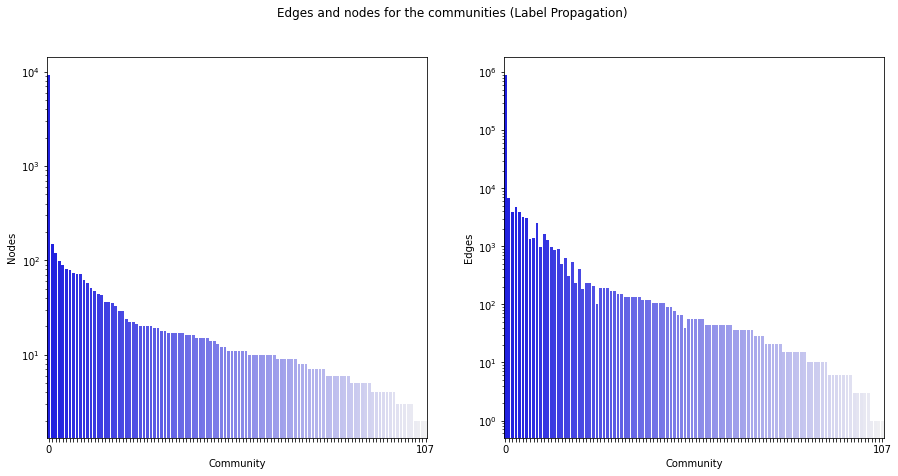

In [41]:
fig, axes = plt.subplots(1,2, figsize=(15, 7))

sns.barplot(ax=axes[0], 
            x=list(info_lp.keys()), 
            y=[c['nodes'] for c in info_lp.values()],
            palette='light:b_r')

axes[0].set_xlabel('Community')
axes[0].set_ylabel('Nodes')
axes[0].set_yscale('log')

# Show only min and max of x tick labels
min_max = [min(list(info_lp.keys())), max(list(info_lp.keys()))]
for index, label in enumerate(axes[0].get_xticklabels()):
   if index in min_max:
      label.set_visible(True)
   else:
      label.set_visible(False)


sns.barplot(ax=axes[1],
            x=list(info_lp.keys()),
            y=[c['edges'] for c in info_lp.values()],
            palette='light:b_r')

axes[1].set_xlabel('Community')
axes[1].set_ylabel('Edges')
axes[1].set_yscale('log')

# Show only min and max of x tick labels
for index, label in enumerate(axes[1].get_xticklabels()):
   if index in min_max:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.suptitle("Edges and nodes for the communities (Label Propagation)")
plt.show()

In [42]:
fitness_functions(lp_coms)

INTERNAL EVALUATION

1 - Average Internal Degree: 
FitnessResult(min=1.0, max=194.6308136426815, score=18.8442581410357, std=26.39105196437351)


2 - Internal Edge Density: 
FitnessResult(min=0.020811678105504865, max=1.0, score=0.9481069277673193, std=0.15455223715201294)


3 - Conductance : 
FitnessResult(min=0.016835587835947532, max=0.5714285714285714, score=0.344580279492796, std=0.1319559418923727)


4 - Triangle Participation Ratio : 
FitnessResult(min=0.0, max=1.0, score=0.9629599930305587, std=0.18885199462371216)


5 - Newmann modularity : 
FitnessResult(min=None, max=None, score=0.08889187188396865, std=None)


6 - Expansion : 
FitnessResult(min=1.0, max=47.44444444444444, score=7.9959156306567865, std=8.269557333306938)


7 - Normalized cut : 
FitnessResult(min=0.05211556500816209, max=0.571436670701358, score=0.34628393276137215, std=0.12901344898105024)


8 - Average ODF Degree : 
FitnessResult(min=1.0, max=47.44444444444444, score=7.9959156306567865, std=8.26955733330693

In [43]:
genre_purity = compute_overall_purity(lp_coms.communities, genre)
w_genre_purity = compute_overall_purity(lp_coms.communities, genre, weighted=False)

In [44]:
publisher_purity = compute_overall_purity(lp_coms.communities, publisher)
w_publisher_purity = compute_overall_purity(lp_coms.communities, publisher, weighted=False)

In [45]:
print(f'GENRE')
print(f'Purity: {genre_purity}, Weighted: {w_genre_purity}')
print(f'Overall Network: {network_genre_purity}')

GENRE
Purity: 0.32446211008381576, Weighted: 0.5390360050610348
Overall Network: 0.2714225053078556


In [46]:
print(f'PUBLISHER')
print(f'Purity: {publisher_purity}, Weighted: {w_publisher_purity}')
print(f'Overall Network: {network_publisher_purity}')

PUBLISHER
Purity: 0.08364296206687967, Weighted: 0.28774392793582715
Overall Network: 0.04704883227176221


### Angel
using : cdlib.algorithms.angel [the faster successor of Demon]
It is a node-centric bottom-up community discovery algorithm. It leverages ego-network structures and overlapping label propagation to identify micro-scale communities that are subsequently merged in mesoscale ones.

In [47]:
#minimum community size, default 3
#threshold – merging threshold in [0,1].

DA_coms = algorithms.angel(g, min_community_size=3, threshold=0.25)

In [48]:
DA_coms.method_name

'ANGEL'

In [49]:
info_DA = info_community(DA_coms.communities, DA_coms)
info_DA

{0: {'nodes': 11317, 'edges': 979291},
 1: {'nodes': 120, 'edges': 6692},
 2: {'nodes': 53, 'edges': 1378},
 3: {'nodes': 12, 'edges': 66},
 4: {'nodes': 12, 'edges': 66},
 5: {'nodes': 12, 'edges': 66},
 6: {'nodes': 11, 'edges': 55},
 7: {'nodes': 10, 'edges': 45},
 8: {'nodes': 9, 'edges': 36},
 9: {'nodes': 8, 'edges': 28},
 10: {'nodes': 7, 'edges': 21},
 11: {'nodes': 6, 'edges': 15},
 12: {'nodes': 6, 'edges': 15},
 13: {'nodes': 5, 'edges': 10}}

In [50]:
print(f"Nodes: {evaluation.size(g, DA_coms)}")
print(f"Edges: {evaluation.edges_inside(g, DA_coms)}")
if DA_coms.overlap: 
    print('Overlapping')
else: print('No overlapping')

Nodes: FitnessResult(min=5, max=11317, score=827.7142857142857, std=2909.357917100596)
Edges: FitnessResult(min=10, max=979291, score=70556.0, std=252043.57300644892)
Overlapping


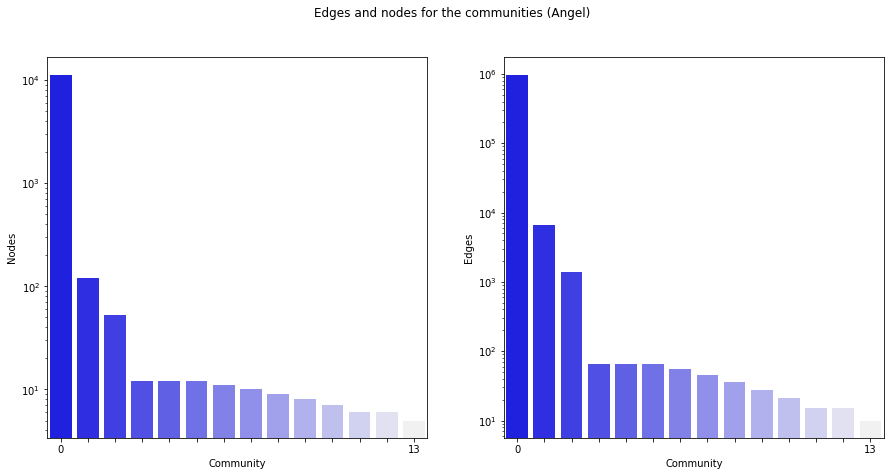

In [51]:
fig, axes = plt.subplots(1,2, figsize=(15, 7))

sns.barplot(ax=axes[0], 
            x=list(info_DA.keys()), 
            y=[c['nodes'] for c in info_DA.values()],
            palette='light:b_r')

axes[0].set_xlabel('Community')
axes[0].set_ylabel('Nodes')
axes[0].set_yscale('log')

# Show only min and max of x tick labels
min_max = [min(list(info_DA.keys())), max(list(info_DA.keys()))]
for index, label in enumerate(axes[0].get_xticklabels()):
   if index in min_max:
      label.set_visible(True)
   else:
      label.set_visible(False)


sns.barplot(ax=axes[1],
            x=list(info_DA.keys()),
            y=[c['edges'] for c in info_DA.values()],
            palette='light:b_r')

axes[1].set_xlabel('Community')
axes[1].set_ylabel('Edges')
axes[1].set_yscale('log')

# Show only min and max of x tick labels
for index, label in enumerate(axes[1].get_xticklabels()):
   if index in min_max:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.suptitle("Edges and nodes for the communities (Angel)")
plt.show()

In [52]:
fitness_functions(DA_coms)

INTERNAL EVALUATION

1 - Average Internal Degree: 
FitnessResult(min=4.0, max=173.0654767164443, score=30.257057860698403, std=48.57798587994909)


2 - Internal Edge Density: 
FitnessResult(min=0.015293873870311442, max=1.0, score=0.9251820554165068, std=0.2528713612154702)


3 - Conductance : 
FitnessResult(min=0.000724998890307821, max=0.9831081081081081, score=0.6157198765034428, std=0.31530794266155915)


4 - Triangle Participation Ratio : 
FitnessResult(min=1.0, max=1.0, score=1.0, std=0.0)


5 - Newmann modularity : 
FitnessResult(min=None, max=None, score=0.01663580201394629, std=None)


6 - Expansion : 
FitnessResult(min=0.12556331183175753, max=232.8, score=46.31905124576584, std=60.25051869243692)


7 - Normalized cut : 
FitnessResult(min=0.07418539363355348, max=0.9836969903751632, score=0.621493215599933, std=0.3049990962447983)


8 - Average ODF Degree : 
FitnessResult(min=0.12556331183175753, max=232.8, score=46.31905124576584, std=60.25051869243692)


9 - Flake ODF : 
Fi

In [53]:
genre_purity = compute_overall_purity(DA_coms.communities, genre)
w_genre_purity = compute_overall_purity(DA_coms.communities, genre, weighted=False)

In [54]:
publisher_purity = compute_overall_purity(DA_coms.communities, publisher)
w_publisher_purity = compute_overall_purity(DA_coms.communities, publisher, weighted=False)

In [55]:
print(f'GENRE')
print(f'Purity: {genre_purity}, Weighted: {w_genre_purity}')
print(f'Overall Network: {network_genre_purity}')

GENRE
Purity: 0.28339661719019676, Weighted: 0.5421635946613904
Overall Network: 0.2714225053078556


In [56]:
print(f'PUBLISHER')
print(f'Purity: {publisher_purity}, Weighted: {w_publisher_purity}')
print(f'Overall Network: {network_publisher_purity}')

PUBLISHER
Purity: 0.05609250949257856, Weighted: 0.3731768585926495
Overall Network: 0.04704883227176221


## Approach 4: Entity Closeness
Communities as a set of nodes that can reach any member of the group crossing a very low number of edges

### Walk-trap



In [57]:
wt_coms = algorithms.walktrap(g)

In [58]:
wt_coms.method_name

'Walktrap'

In [59]:
info_wt = info_community(wt_coms.communities, wt_coms)
info_wt

{0: {'nodes': 1760, 'edges': 66659},
 1: {'nodes': 1463, 'edges': 139215},
 2: {'nodes': 1331, 'edges': 50701},
 3: {'nodes': 1264, 'edges': 73074},
 4: {'nodes': 312, 'edges': 48516},
 5: {'nodes': 287, 'edges': 39378},
 6: {'nodes': 244, 'edges': 29404},
 7: {'nodes': 236, 'edges': 20301},
 8: {'nodes': 211, 'edges': 22155},
 9: {'nodes': 184, 'edges': 16836},
 10: {'nodes': 179, 'edges': 15931},
 11: {'nodes': 169, 'edges': 13546},
 12: {'nodes': 157, 'edges': 12246},
 13: {'nodes': 138, 'edges': 9453},
 14: {'nodes': 116, 'edges': 6670},
 15: {'nodes': 113, 'edges': 6116},
 16: {'nodes': 113, 'edges': 6328},
 17: {'nodes': 98, 'edges': 3265},
 18: {'nodes': 90, 'edges': 4005},
 19: {'nodes': 90, 'edges': 4005},
 20: {'nodes': 89, 'edges': 3506},
 21: {'nodes': 89, 'edges': 3916},
 22: {'nodes': 80, 'edges': 3160},
 23: {'nodes': 79, 'edges': 3081},
 24: {'nodes': 77, 'edges': 2926},
 25: {'nodes': 75, 'edges': 2775},
 26: {'nodes': 71, 'edges': 2485},
 27: {'nodes': 69, 'edges': 23

In [61]:
print(f"Nodes: {evaluation.size(g, wt_coms)}")
print(f"Edges: {evaluation.edges_inside(g, wt_coms)}")
if wt_coms.overlap: 
    print('Overlapping')
else: print('No overlapping')

Nodes: FitnessResult(min=1, max=1760, score=63.240437158469945, std=216.0130716137466)
Edges: FitnessResult(min=0, max=139215, score=3525.9781420765025, std=14096.483585064861)
No overlapping


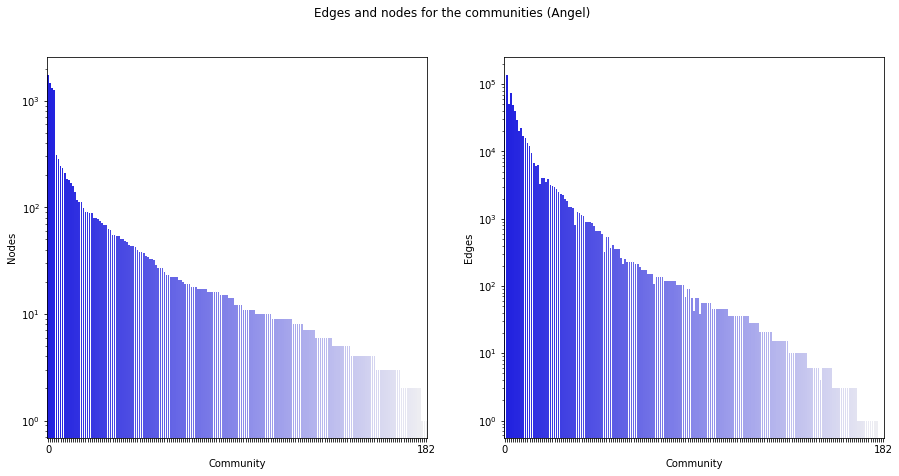

In [62]:
fig, axes = plt.subplots(1,2, figsize=(15, 7))

sns.barplot(ax=axes[0], 
            x=list(info_wt.keys()), 
            y=[c['nodes'] for c in info_wt.values()],
            palette='light:b_r')

axes[0].set_xlabel('Community')
axes[0].set_ylabel('Nodes')
axes[0].set_yscale('log')

# Show only min and max of x tick labels
min_max = [min(list(info_wt.keys())), max(list(info_wt.keys()))]
for index, label in enumerate(axes[0].get_xticklabels()):
   if index in min_max:
      label.set_visible(True)
   else:
      label.set_visible(False)


sns.barplot(ax=axes[1],
            x=list(info_wt.keys()),
            y=[c['edges'] for c in info_wt.values()],
            palette='light:b_r')

axes[1].set_xlabel('Community')
axes[1].set_ylabel('Edges')
axes[1].set_yscale('log')

# Show only min and max of x tick labels
for index, label in enumerate(axes[1].get_xticklabels()):
   if index in min_max:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.suptitle("Edges and nodes for the communities (Angel)")
plt.show()

In [63]:
fitness_functions(DA_coms)

INTERNAL EVALUATION

1 - Average Internal Degree: 
FitnessResult(min=4.0, max=173.0654767164443, score=30.257057860698403, std=48.57798587994909)


2 - Internal Edge Density: 
FitnessResult(min=0.015293873870311442, max=1.0, score=0.9251820554165068, std=0.2528713612154702)


3 - Conductance : 
FitnessResult(min=0.000724998890307821, max=0.9831081081081081, score=0.6157198765034428, std=0.31530794266155915)


4 - Triangle Participation Ratio : 
FitnessResult(min=1.0, max=1.0, score=1.0, std=0.0)


5 - Newmann modularity : 
FitnessResult(min=None, max=None, score=0.01663580201394629, std=None)


6 - Expansion : 
FitnessResult(min=0.12556331183175753, max=232.8, score=46.31905124576584, std=60.25051869243692)


7 - Normalized cut : 
FitnessResult(min=0.07418539363355348, max=0.9836969903751632, score=0.621493215599933, std=0.3049990962447983)


8 - Average ODF Degree : 
FitnessResult(min=0.12556331183175753, max=232.8, score=46.31905124576584, std=60.25051869243692)


9 - Flake ODF : 
Fi

In [64]:
genre_purity = compute_overall_purity(DA_coms.communities, genre)
w_genre_purity = compute_overall_purity(DA_coms.communities, genre, weighted=False)

In [65]:
publisher_purity = compute_overall_purity(DA_coms.communities, publisher)
w_publisher_purity = compute_overall_purity(DA_coms.communities, publisher, weighted=False)

In [66]:
print(f'GENRE')
print(f'Purity: {genre_purity}, Weighted: {w_genre_purity}')
print(f'Overall Network: {network_genre_purity}')

GENRE
Purity: 0.28339661719019676, Weighted: 0.5421635946613904
Overall Network: 0.2714225053078556


In [67]:
print(f'PUBLISHER')
print(f'Purity: {publisher_purity}, Weighted: {w_publisher_purity}')
print(f'Overall Network: {network_publisher_purity}')

PUBLISHER
Purity: 0.05609250949257856, Weighted: 0.3731768585926495
Overall Network: 0.04704883227176221


# External Evaluation: Partition Comparisons

## Partitions comparison scores
Compare different graph partition to assess their resemblance.

In [68]:
algs = [lp_coms, louv_coms, DA_coms, wt_coms]
#algs = [louv_coms, lp_coms] # test

In [69]:
combinations = list(itertools.combinations(algs, 2))

In [70]:
for combination in combinations:
    print(f"NF1 {combination[0].method_name} - {combination[1].method_name} = {evaluation.nf1(combination[0], combination[1])}")
    print()

NF1 Label Propagation - Louvain = MatchingResult(score=0.023257133058984907, std=None)

NF1 Label Propagation - ANGEL = MatchingResult(score=0.016353276353276356, std=None)

NF1 Label Propagation - Walktrap = MatchingResult(score=0.5695628415300545, std=None)

NF1 Louvain - ANGEL = MatchingResult(score=0.008265142857142856, std=None)

NF1 Louvain - Walktrap = MatchingResult(score=0.0664343606557377, std=None)

NF1 ANGEL - Walktrap = MatchingResult(score=0.06721311475409837, std=None)



In [71]:
for combination in combinations:
    print(f"ONMI {combination[0].method_name} - {combination[1].method_name} = {evaluation.overlapping_normalized_mutual_information_LFK(combination[0], combination[1])}")
    print()

ONMI Label Propagation - Louvain = MatchingResult(score=0.1851296764127799, std=None)

ONMI Label Propagation - ANGEL = MatchingResult(score=0.462596319702552, std=None)

ONMI Label Propagation - Walktrap = MatchingResult(score=0.7696679591128319, std=None)

ONMI Louvain - ANGEL = MatchingResult(score=0.15245905449953323, std=None)

ONMI Louvain - Walktrap = MatchingResult(score=0.29738111219448093, std=None)

ONMI ANGEL - Walktrap = MatchingResult(score=0.440999984407593, std=None)



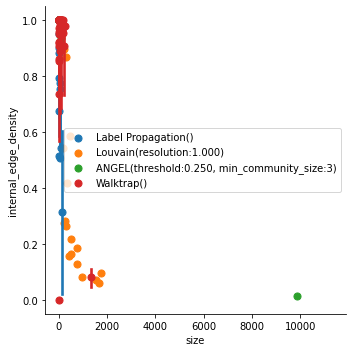

In [72]:
viz.plot_com_properties_relation(algs, evaluation.size, evaluation.internal_edge_density)

In [73]:
method_names = [alg.method_name for alg in algs]

In [74]:
f1_scores = list()
for alg1 in algs:
    f1_score = [evaluation.nf1(alg1, alg2).score for alg2 in algs]
    f1_scores.append(f1_score)

In [75]:
ONMI_scores = list()
for alg1 in algs:
    ONMI_score = [evaluation.overlapping_normalized_mutual_information_LFK(alg1, alg2).score for alg2 in algs]
    ONMI_scores.append(ONMI_score)

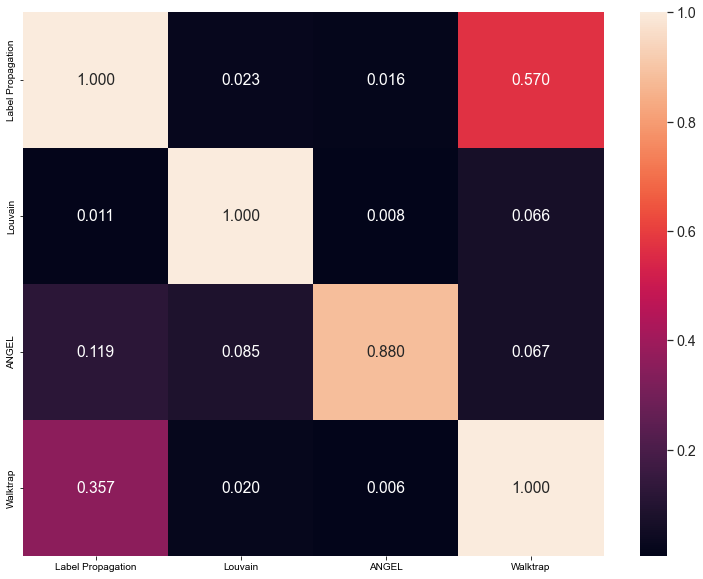

In [76]:
fig, ax = plt.subplots(figsize=(13,10))

sns.set(font_scale=1.3)
ax = sns.heatmap(f1_scores, annot=True, fmt='.3f', xticklabels=method_names, yticklabels=method_names)

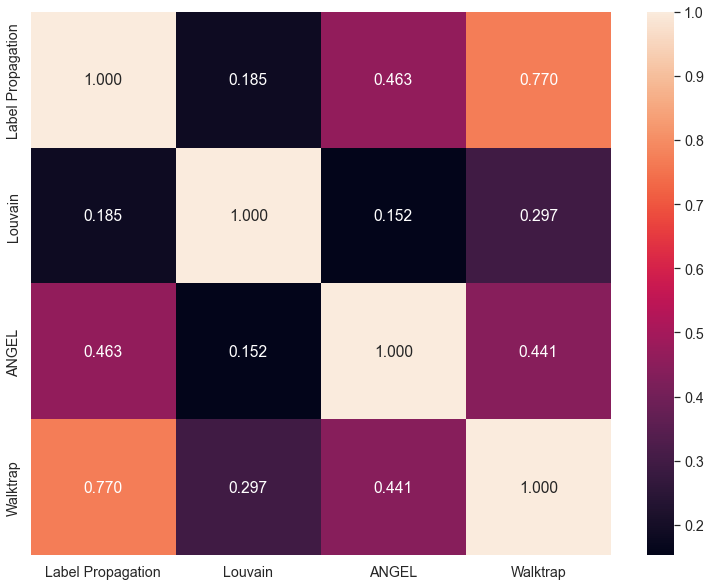

In [77]:
fig, ax = plt.subplots(figsize=(13,10))

sns.set(font_scale=1.3)
ax = sns.heatmap(ONMI_scores, annot=True, fmt='.3f', xticklabels=method_names, yticklabels=method_names)

In [78]:
!pip install tikzplotlib

In [79]:
import tikzplotlib

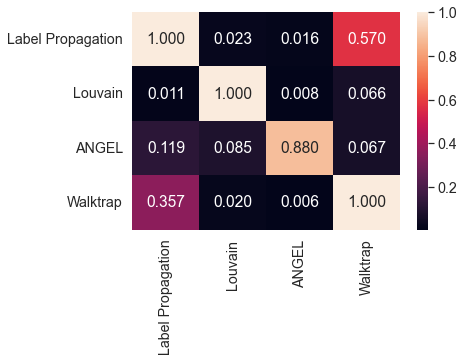

In [80]:
fig, ax = plt.subplots()

sns.set(font_scale=1.3)
ax = sns.heatmap(f1_scores, annot=True, fmt='.3f', xticklabels=method_names, yticklabels=method_names)
tikzplotlib.save("plots/heatmap-f1-comparison.tex")

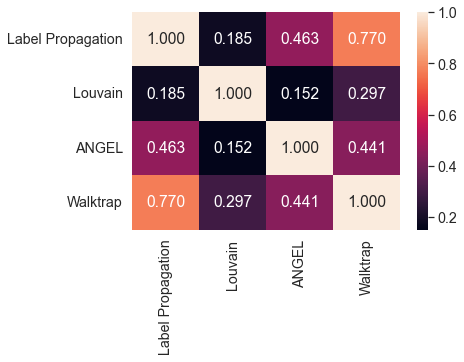

In [81]:
fig, ax = plt.subplots()

sns.set(font_scale=1.3)
ax = sns.heatmap(ONMI_scores, annot=True, fmt='.3f', xticklabels=method_names, yticklabels=method_names)
tikzplotlib.save("plots/heatmap-ONMI-comparison.tex")